<a href="https://colab.research.google.com/github/milanbargiel/csma/blob/main/Clustering_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python --version

Python 3.7.10


# Install dependencies:

In [ ]:
!pip install umap-learn
!pip install scikit-learn-extra 
!pip install numba --upgrade

     |████████████████████████████████| 624kB 11.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp37-cp37m-linux_x86_64.whl size=339942 sha256=8b4e614dc403d727921bc98dd158f9c6e6eac7ff6ec7721779866907464bd54a
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra
     |████████████████████████████████| 3.4MB 10.1MB/s 
     |████████████████████████████████| 25.3MB 1.3MB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


# Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [ ]:
# Save and load your data after clustering
def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [ ]:
input_path = "/content/drive/My Drive/CSMA/Data/embeddings/grouped_by_year/"
output_path = "/content/drive/My Drive/CSMA/clustering_experiments_milan/output_clusters/"

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

In [ ]:
umap_num_dimensions = 100   # Number of dimensions to reduce to
umap_n_neighbors = 10       # 

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [ ]:
data = pd.read_pickle(input_path+'2020/data_preprocessed_2020'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [ ]:
embeddings = np.load(input_path+'2020/embeddings'+model_type+'_2020.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [ ]:
reducer_clustering = umap.UMAP(n_neighbors=umap_n_neighbors, 
                     n_components=umap_num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.5790271
n_clusters: 12 silhouette_avg: 0.35441938
n_clusters: 22 silhouette_avg: 0.31303197
n_clusters: 32 silhouette_avg: 0.32688192
n_clusters: 42 silhouette_avg: 0.34205797
n_clusters: 52 silhouette_avg: 0.33604735
n_clusters: 62 silhouette_avg: 0.3290002
n_clusters: 72 silhouette_avg: 0.34902546
n_clusters: 82 silhouette_avg: 0.34046432
n_clusters: 92 silhouette_avg: 0.33377337


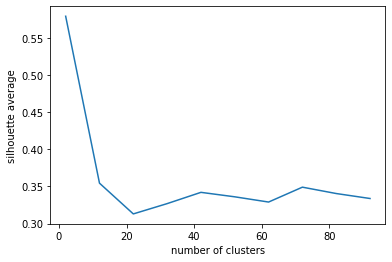

In [ ]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=100 
step=10 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [ ]:
number_of_clusters =  72
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 3       4
7       7
11      8
23      8
70     16
22     18
36     26
28     31
69     34
57     37
48     39
43     45
40     48
38     49
15     49
50     50
35     53
71     69
21     70
45     76
63     79
5      83
6      84
61     92
2      94
51     94
62     97
65     98
49     98
58    103
20    122
67    125
18    134
42    139
17    145
56    162
12    164
14    166
44    169
66    172
64    187
52    195
32    202
46    210
4     212
55    212
60    237
59    241
27    251
68    252
53    257
10    273
54    278
41    283
31    344
25    349
29    350
0     353
1     353
39    354
47    362
30    362
34    367
8     377
24    381
19    387
16    396
26    409
9     439
13    454
37    490
33    495
Name: label_kmedoids, dtype: int64


In [ ]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [ ]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=20, #50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

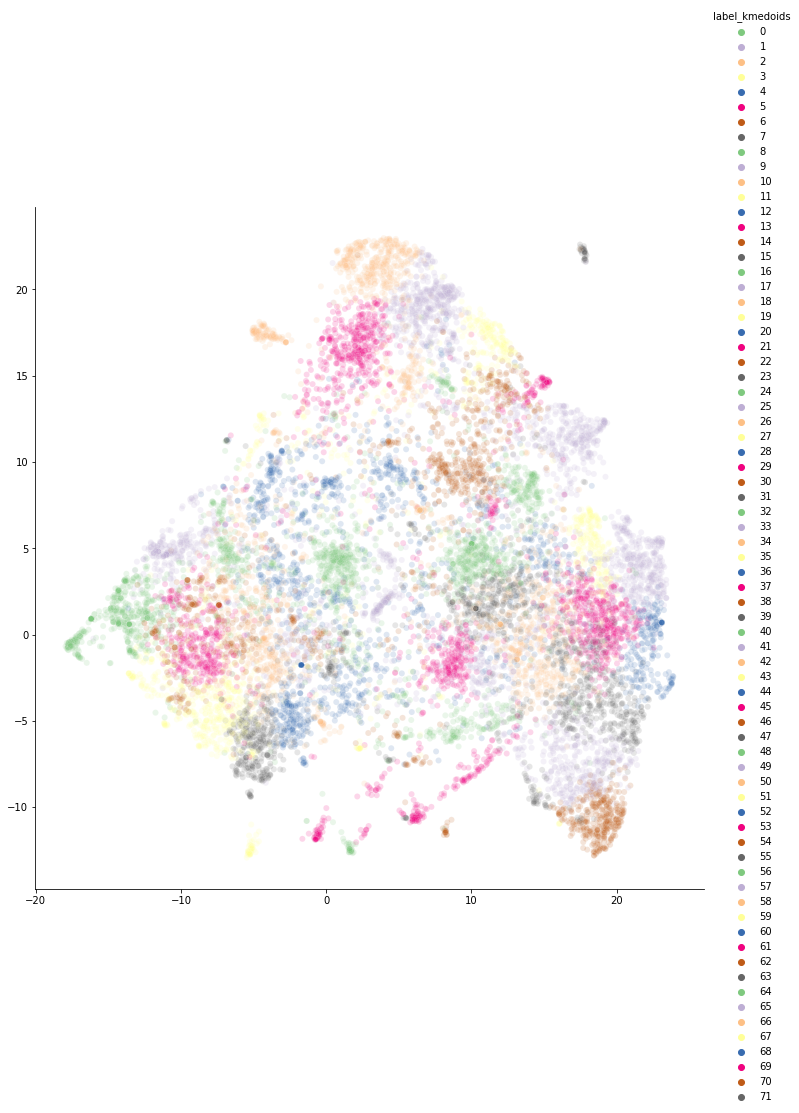

In [ ]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

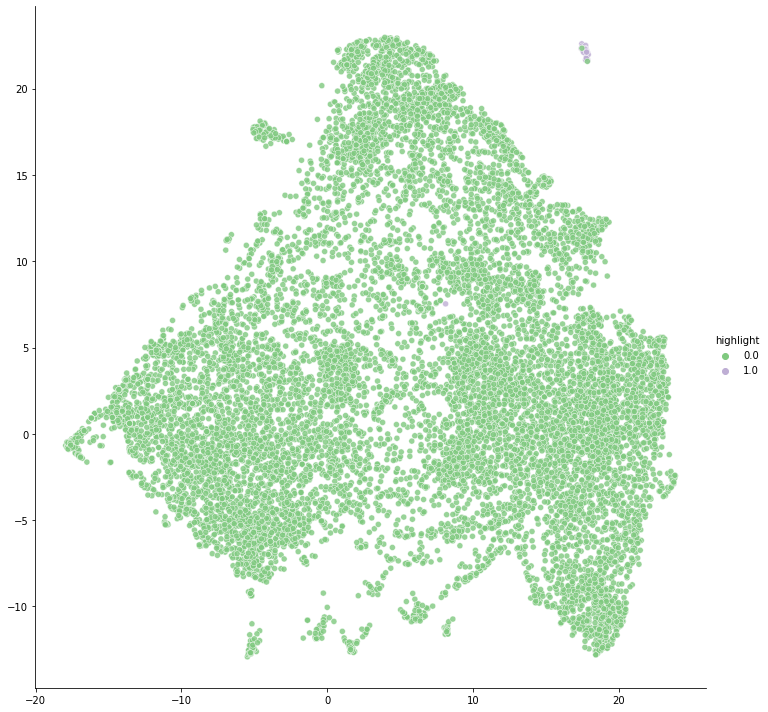

In [ ]:
## Choose a cluster to higlight:
cluster_num = 15

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [ ]:
# print the medoids 
data.iloc[medoids_indices]      

,Unnamed: 0,publishedAt,authorName,text,isReply,video_id,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
12074,54138,2020-11-26 04:08:44,Timmsy Skies,You got it!!,1,b1Enrzgrl1w,You got it!!,-1.0,0,0.000000e+00,0.0
8238,32531,2020-03-17 15:24:22,Elyjah Stark,"Keith Seigel and right on cue, he repeats the tired old cue. Why are you lying Keith? Why are you so fascinated with my career choice? Are you upset that you didn’t do anything with your life except watch youtube all day? “You claimed that contrails are in fact Chemtrails” yes, semantically, because water is a chemical. Do you not understand? I’m not surprised you don’t. Thanks for admitting you are being deceitful trying to use my words as proof Chemtrails exist. What a sad life you have, boom! “Prove Chemtrails don’t exist” you already did. But if you want to go over it again we can go over some of the differences. Let’s start with two topics. Explain the phase gap between the engines and the trails. Also, using this document, let me know how much a measured persistent trail weighs. http://cires1.colorado.edu/science/groups/pielke/classes/atoc7500/knollenberg72.pdf Let me know if you need help reading it. You’ll need to apply some math if you remember how to do that. “Prove you are an aeronautic engineer” I really don’t care if you believe me or not. The fact of the matter is I am. That holds no bearing on the validity of the evidence and the underlying laws of physics which prove you wrong. But the appeal to authority fallacy is strong with you. You are trying so hard to negate my career while you parade around with no educational background. Hilarious. You should join a comedy club. Now let’s see your proof? Do you have any?",1,wpSRp_R0J9A,"Keith Seigel and right on cue, he repeats the tired old cue. Why are you lying Keith? Why are you so fascinated with my career choice? Are you upset that you didn’t do anything with your life except watch youtube all day? “You claimed that contrails are in fact Chemtrails” yes, semantically, because water is a chemical. Do you not understand? I’m not surprised you don’t. Thanks for admitting you are being deceitful trying to use my words as proof Chemtrails exist. What a sad life you have, boom! “Prove Chemtrails don’t exist” you already did. But if you want to go over it again we can go over some of the differences. Let’s start with two topics. Explain the phase gap between the engines and the trails. Also, using this document, let me know how much a measured persistent trail weighs. Let me know if you need help reading it. You’ll need to apply some math if you remember how to do that. “Prove you are an aeronautic engineer” I really don’t care if you believe me or not. The fact of the matter is I am. That holds no bearing on the validity of the evidence and the underlying laws of physics which prove you wrong. But the appeal to authority fallacy is strong with you. You are trying so hard to negate my career while you parade around with no educational background. Hilarious. You should join a comedy club. Now let’s see your proof? Do you have any?",-1.0,1,0.000000e+00,0.0
11519,53569,2020-12-13 19:09:14,I-Rises I,"No Wicked, you can&#39;t take the Sun, but can you manipulate the Sun. Try it and see, that&#39;s why you all want to get Reed of natural Trees. But Redemption day is coming. <br />GIVE THANK TO MOTHER NATURE",0,b1Enrzgrl1w,"No Wicked, you can't take the Sun, but can you manipulate the Sun. Try it and see, that's why you all want to get Reed of natural Trees. But Redemption day is coming. GIVE THANK TO MOTHER NATURE",-1.0,2,5.960464e-08,0.0
8533,35407,2020-10-26 13:23:33,Elyjah Stark,"My favorite part of the comment that “BicBoi” “Noah” “Elyjah Stark” (fake with the pixelated picture) and “Rick Astley” and whoever else he tries to create profiles for, is that he thinks he’s accomplished by being young, a gamer, and a “lifter”, even though he’s scrawny as shit 😂😂😂. And he’s so embarrassed that he has to delet

In [ ]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [ ]:
# Choose a cluster to print
cluster_number =   42
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 139
Average Distance from cluster center: 6.760195901733823e-06


,Unnamed: 0,publishedAt,authorName,text,isReply,video_id,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
6573,30050,2020-03-18 09:46:41,Bob Cat,"Bill Gates new vaccine just paralyzed approximately 50, 000 children in India; he addministered some of the doses himself; anyone hear about this on main stream mediia; he should be executed. Evidently the allegedly weakened virus wasn't weak enough; strange, most of the people who know about viruses can't even agree if a virus is actually life. Did you know that Bill Gates own children aren't vaccinated; digest that one. My heart goes out to all those children and their mothers; I'm truely sick of this stupidity and insanity.",1,wpSRp_R0J9A,"Bill Gates new vaccine just paralyzed approximately 50, 000 children in India; he addministered some of the doses himself; anyone hear about this on main stream mediia; he should be executed. Evidently the allegedly weakened virus wasn't weak enough; strange, most of the people who know about viruses can't even agree if a virus is actually life. Did you know that Bill Gates own children aren't vaccinated; digest that one. My heart goes out to all those children and their mothers; I'm truely sick of this stupidity and insanity.",-1.0,42,0.000000e+00,0.0
10589,51020,2020-05-09 12:33:35,diane sykes,"They are like the mad scientists you used to see in old horror films!! I absolutely detest Bill Gates who, actually, with all of his money, seems untouchable with his evil experiments. Look into his parents and his history. He thinks he is on parr with ""The creator"" and he is getting away with it. Having so much money, he can, and probably is, dictating the narrative. These people are puppets of the Devil, which by the way, we will be also if we accept his vaccines and chips!!",1,WR6uSXW-8p4,"They are like the mad scientists you used to see in old horror films!! I absolutely detest Bill Gates who, actually, with all of his money, seems untouchable with his evil experiments. Look into his parents and his history. He thinks he is on parr with ""The creator"" and he is getting away with it. Having so much money, he can, and probably is, dictating the narrative. These people are puppets of the Devil, which by the way, we will be also if we accept his vaccines and chips!!",-1.0,42,1.788139e-07,0.0
10099,50525,2020-10-22 03:26:22,NEWS,"<a href=""http://geoengineeringwatch.org/"">GeoengineeringWatch.org</a> since 75 plus years, Bill Gates is a psycho , it is not nothing new, only furthering the demise of earth by 2026 acc to NASA engineer. Could, would, insanity, it has been here very existent.",0,WR6uSXW-8p4,"GeoengineeringWatch.org since 75 plus years, Bill Gates is a psycho , it is not nothing new, only furthering the demise of earth by 2026 acc to NASA engineer. Could, would, insanity, it has been here very existent.",-1.0,42,2.384186e-07,0.0
10043,50469,2020-11-22 04:31:57,Walter Smith,Bill Gates is a billionaire that wants to play god. His father was a founder of Eugenics. A term used to disguise the <br />Depopulation Agenda and Infanticide.<br /> Gates enjoys injecting poison into life.,0,WR6uSXW-8p4,Bill Gates is a billionaire that wants to play god. His father was a founder of Eugenics. A term used to disguise the Depopulation Agenda and Infanticide. Gates enjoys injecting poison into life.,-1.0,42,2.980232e-07,0.0
10392,50822,2020-06-03 01:16:06,Cynthia Walton,"Bill Gates is such a moron. The Earth needs to be left alone. God knows how this would affect the health of the planet, the inhabitants long term.",0,WR6uSXW-8p4,"Bill Gates is such a moron. The Earth needs to be left alone. God knows how this would affect the health of the planet, the inhabitants long term.",-1.0,42,4.172325e-07,0.0
10610,51041,2020-04-23 23:55:12,SOAP BOX ART,"I have to say Bill Gates is about the most insane stupid idiot on the planet! You block the sun you block life on the planet without Sun there is no growth without sun there Is Only death, you block t